In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 20:34:20.908857
thunder  Sun Dec 22 20:34:21 2019
[0] GeForce GTX 1080 Ti | 48'C,  19 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 20:34:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 34%   49C    P2    79W / 250W |  10895MiB / 11178MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   26C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:84]:
        layer.trainable = False
    for layer in mobile_conv.layers[84:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,051,649
Non-trainable params: 2,178,240
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 23s 456ms/step - loss: 0.7122 - Accuracy: 0.5612 - Precision: 0.5603 - Recall: 0.5458 - F1: 0.5425 - AUC: 0.5953 - val_loss: 1.3368 - val_Accuracy: 0.0562 - val_Precision: 0.0226 - val_Recall: 0.5667 - val_F1: 0.0430 - val_AUC: 0.7434
Epoch 2/150
50/50 [==============================] - 20s 405ms/step - loss: 0.6540 - Accuracy: 0.6162 - Precision: 0.6125 - Recall: 0.6338 - F1: 0.6147 - AUC: 0.6682 - val_loss: 1.2662 - val_Accuracy: 0.0875 - val_Precision: 0.0169 - val_Recall: 0.3667 - val_F1: 0.0319 - val_AUC: 0.6298
Epoch 3/150
50/50 [==============================] - 21s 422ms/step - loss: 0.6733 - Accuracy: 0.6131 - Precision: 0.6071 - Recall: 0.6025 - F1: 0.5986 - AUC: 0.6543 - val_loss: 1.4667 - val_Accuracy: 0.0812 - val_Precision: 0.0199 - val_Recall: 0.6000 - val_F1: 0.0385 - val_AUC: 0.5157
Epoch 4/150
50/50 [==============================] - 22s 430ms/step - loss: 0.6589 - Accuracy: 0.6275 - Precision: 0.6342 - Recall: 0.64

Epoch 29/150
50/50 [==============================] - 21s 414ms/step - loss: 0.5876 - Accuracy: 0.6812 - Precision: 0.6978 - Recall: 0.6909 - F1: 0.6863 - AUC: 0.7513 - val_loss: 0.9583 - val_Accuracy: 0.3656 - val_Precision: 0.0243 - val_Recall: 0.4000 - val_F1: 0.0457 - val_AUC: 0.6423
Epoch 30/150
50/50 [==============================] - 22s 430ms/step - loss: 0.5980 - Accuracy: 0.6762 - Precision: 0.6850 - Recall: 0.6985 - F1: 0.6821 - AUC: 0.7387 - val_loss: 0.8445 - val_Accuracy: 0.4187 - val_Precision: 0.0105 - val_Recall: 0.1000 - val_F1: 0.0190 - val_AUC: 0.4383
Epoch 31/150
50/50 [==============================] - 22s 431ms/step - loss: 0.5796 - Accuracy: 0.6844 - Precision: 0.6781 - Recall: 0.7002 - F1: 0.6828 - AUC: 0.7604 - val_loss: 0.8542 - val_Accuracy: 0.3906 - val_Precision: 0.0302 - val_Recall: 0.5000 - val_F1: 0.0569 - val_AUC: 0.6335
Epoch 32/150
50/50 [==============================] - 27s 532ms/step - loss: 0.5856 - Accuracy: 0.6913 - Precision: 0.6962 - Recall: 

50/50 [==============================] - 21s 425ms/step - loss: 0.5811 - Accuracy: 0.6894 - Precision: 0.6853 - Recall: 0.7085 - F1: 0.6915 - AUC: 0.7579 - val_loss: 0.9730 - val_Accuracy: 0.3469 - val_Precision: 0.0475 - val_Recall: 0.5500 - val_F1: 0.0865 - val_AUC: 0.6040
Epoch 58/150
50/50 [==============================] - 24s 489ms/step - loss: 0.5936 - Accuracy: 0.6769 - Precision: 0.6600 - Recall: 0.7113 - F1: 0.6775 - AUC: 0.7446 - val_loss: 0.9857 - val_Accuracy: 0.3781 - val_Precision: 0.0263 - val_Recall: 0.4000 - val_F1: 0.0491 - val_AUC: 0.5849
Epoch 59/150
50/50 [==============================] - 21s 421ms/step - loss: 0.5724 - Accuracy: 0.7038 - Precision: 0.7155 - Recall: 0.7112 - F1: 0.7065 - AUC: 0.7724 - val_loss: 0.9229 - val_Accuracy: 0.4031 - val_Precision: 0.0459 - val_Recall: 0.6000 - val_F1: 0.0846 - val_AUC: 0.6990
Epoch 60/150
50/50 [==============================] - 21s 429ms/step - loss: 0.5921 - Accuracy: 0.6900 - Precision: 0.7023 - Recall: 0.7019 - F1: 

50/50 [==============================] - 25s 493ms/step - loss: 0.5912 - Accuracy: 0.6794 - Precision: 0.6626 - Recall: 0.7070 - F1: 0.6777 - AUC: 0.7468 - val_loss: 0.9015 - val_Accuracy: 0.3969 - val_Precision: 0.0488 - val_Recall: 0.6167 - val_F1: 0.0887 - val_AUC: 0.5813
Epoch 86/150
50/50 [==============================] - 21s 415ms/step - loss: 0.5791 - Accuracy: 0.6988 - Precision: 0.7065 - Recall: 0.7181 - F1: 0.7052 - AUC: 0.7671 - val_loss: 0.7956 - val_Accuracy: 0.3844 - val_Precision: 0.0569 - val_Recall: 0.8500 - val_F1: 0.1045 - val_AUC: 0.6206
Epoch 87/150
50/50 [==============================] - 21s 424ms/step - loss: 0.5594 - Accuracy: 0.7113 - Precision: 0.7043 - Recall: 0.7376 - F1: 0.7159 - AUC: 0.7866 - val_loss: 0.7913 - val_Accuracy: 0.3781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2947
Epoch 88/150
50/50 [==============================] - 24s 486ms/step - loss: 0.5839 - Accuracy: 0.6894 - Precision: 0.6952 - Recall: 0

50/50 [==============================] - 21s 426ms/step - loss: 0.6078 - Accuracy: 0.6675 - Precision: 0.6573 - Recall: 0.6862 - F1: 0.6654 - AUC: 0.7285 - val_loss: 0.8671 - val_Accuracy: 0.3656 - val_Precision: 0.0246 - val_Recall: 0.4000 - val_F1: 0.0460 - val_AUC: 0.7301
Epoch 114/150
50/50 [==============================] - 22s 443ms/step - loss: 0.5797 - Accuracy: 0.6888 - Precision: 0.7147 - Recall: 0.6927 - F1: 0.6979 - AUC: 0.7644 - val_loss: 0.9473 - val_Accuracy: 0.3812 - val_Precision: 0.0441 - val_Recall: 0.5000 - val_F1: 0.0799 - val_AUC: 0.6595
Epoch 115/150
50/50 [==============================] - 25s 507ms/step - loss: 0.5652 - Accuracy: 0.7125 - Precision: 0.7115 - Recall: 0.7265 - F1: 0.7125 - AUC: 0.7784 - val_loss: 0.7695 - val_Accuracy: 0.3969 - val_Precision: 0.0437 - val_Recall: 0.5250 - val_F1: 0.0791 - val_AUC: 0.6992
Epoch 116/150
50/50 [==============================] - 22s 442ms/step - loss: 0.6057 - Accuracy: 0.6831 - Precision: 0.6659 - Recall: 0.7209 - F

50/50 [==============================] - 24s 486ms/step - loss: 0.5829 - Accuracy: 0.6969 - Precision: 0.6935 - Recall: 0.7199 - F1: 0.7004 - AUC: 0.7607 - val_loss: 0.8049 - val_Accuracy: 0.4125 - val_Precision: 0.0319 - val_Recall: 0.5000 - val_F1: 0.0596 - val_AUC: 0.6560
Epoch 142/150
50/50 [==============================] - 22s 434ms/step - loss: 0.5650 - Accuracy: 0.7119 - Precision: 0.7159 - Recall: 0.7314 - F1: 0.7149 - AUC: 0.7786 - val_loss: 0.8882 - val_Accuracy: 0.3656 - val_Precision: 0.0270 - val_Recall: 0.6000 - val_F1: 0.0516 - val_AUC: 0.5602
Epoch 143/150
50/50 [==============================] - 22s 435ms/step - loss: 0.5777 - Accuracy: 0.6856 - Precision: 0.6872 - Recall: 0.7020 - F1: 0.6865 - AUC: 0.7638 - val_loss: 0.7885 - val_Accuracy: 0.3906 - val_Precision: 0.0287 - val_Recall: 0.5000 - val_F1: 0.0542 - val_AUC: 0.5172
Epoch 144/150
50/50 [==============================] - 24s 488ms/step - loss: 0.5783 - Accuracy: 0.6963 - Precision: 0.6854 - Recall: 0.7300 - F

In [21]:
print("Time taken:",end-start)

Time taken: 3375.6810779571533


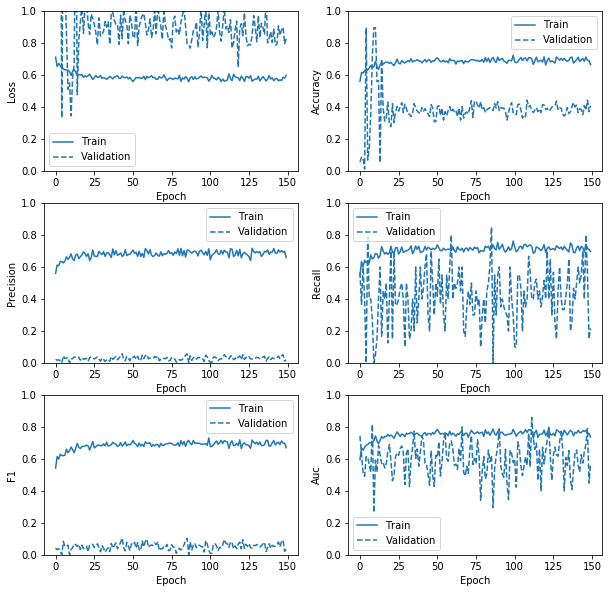

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/150
50/50 [==============================] - 21s 427ms/step - loss: 0.7009 - Accuracy: 0.5625 - Precision: 0.1460 - Recall: 0.7693 - F1: 0.2400 - AUC: 0.7544 - val_loss: 0.9108 - val_Accuracy: 0.3469 - val_Precision: 0.0245 - val_Recall: 0.4500 - val_F1: 0.0464 - val_AUC: 0.5621
Epoch 2/150
50/50 [==============================] - 23s 459ms/step - loss: 0.6592 - Accuracy: 0.6144 - Precision: 0.1734 - Recall: 0.7479 - F1: 0.2701 - AUC: 0.7478 - val_loss: 0.8288 - val_Accuracy: 0.3438 - val_Precision: 0.0228 - val_Recall: 0.3500 - val_F1: 0.0425 - val_AUC: 0.5630
Epoch 3/150
50/50 [==============================] - 20s 404ms/step - loss: 0.6325 - Accuracy: 0.6306 - Precision: 0.1596 - Recall: 0.8048 - F1: 0.2560 - AUC: 0.7841 - val_loss: 0.8647 - val_Accuracy: 0.4375 - val_Precision: 0.0397 - val_Recall: 0.5000 - val_F1: 0.0726 - val_AUC: 0.6095
Epoch 4/150
50/50 [==============================] - 20s 406ms/step - loss: 0.6107 - Accuracy: 0.6544 - Precision: 0.1598 - Recall: 0.65

50/50 [==============================] - 20s 396ms/step - loss: 0.3666 - Accuracy: 0.8894 - Precision: 0.3730 - Recall: 0.2840 - F1: 0.3064 - AUC: 0.7652 - val_loss: 0.6575 - val_Accuracy: 0.6125 - val_Precision: 0.0593 - val_Recall: 0.5000 - val_F1: 0.1021 - val_AUC: 0.5983
Epoch 30/150
50/50 [==============================] - 19s 388ms/step - loss: 0.3607 - Accuracy: 0.8869 - Precision: 0.2650 - Recall: 0.2369 - F1: 0.2195 - AUC: 0.7554 - val_loss: 0.5850 - val_Accuracy: 0.5813 - val_Precision: 0.0289 - val_Recall: 0.4000 - val_F1: 0.0538 - val_AUC: 0.6058
Epoch 31/150
50/50 [==============================] - 24s 472ms/step - loss: 0.3604 - Accuracy: 0.8763 - Precision: 0.2950 - Recall: 0.1963 - F1: 0.2256 - AUC: 0.7815 - val_loss: 0.6268 - val_Accuracy: 0.5844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5079
Epoch 32/150
50/50 [==============================] - 20s 397ms/step - loss: 0.3496 - Accuracy: 0.9000 - Precision: 0.2933 - Recall: 0

50/50 [==============================] - 20s 394ms/step - loss: 0.2974 - Accuracy: 0.9075 - Precision: 0.0900 - Recall: 0.0235 - F1: 0.0363 - AUC: 0.7560 - val_loss: 0.4019 - val_Accuracy: 0.7937 - val_Precision: 0.0876 - val_Recall: 0.2917 - val_F1: 0.1253 - val_AUC: 0.6262
Epoch 58/150
50/50 [==============================] - 20s 394ms/step - loss: 0.3043 - Accuracy: 0.9056 - Precision: 0.2000 - Recall: 0.0747 - F1: 0.1041 - AUC: 0.7370 - val_loss: 0.4267 - val_Accuracy: 0.8156 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.6181
Epoch 59/150
50/50 [==============================] - 24s 480ms/step - loss: 0.2921 - Accuracy: 0.9150 - Precision: 0.2500 - Recall: 0.0925 - F1: 0.1250 - AUC: 0.7487 - val_loss: 0.5142 - val_Accuracy: 0.7719 - val_Precision: 0.0143 - val_Recall: 0.0500 - val_F1: 0.0222 - val_AUC: 0.5652
Epoch 60/150
50/50 [==============================] - 20s 396ms/step - loss: 0.3049 - Accuracy: 0.8956 - Precision: 0.1000 - Recall: 0.0347 - F1: 

Epoch 85/150
50/50 [==============================] - 24s 481ms/step - loss: 0.2817 - Accuracy: 0.9062 - Precision: 0.1000 - Recall: 0.0290 - F1: 0.0440 - AUC: 0.7574 - val_loss: 0.3997 - val_Accuracy: 0.9000 - val_Precision: 0.0250 - val_Recall: 0.0333 - val_F1: 0.0286 - val_AUC: 0.6387
Epoch 86/150
50/50 [==============================] - 20s 402ms/step - loss: 0.2798 - Accuracy: 0.9069 - Precision: 0.0900 - Recall: 0.0280 - F1: 0.0413 - AUC: 0.7587 - val_loss: 0.3403 - val_Accuracy: 0.8406 - val_Precision: 0.0500 - val_Recall: 0.2000 - val_F1: 0.0786 - val_AUC: 0.4678
Epoch 87/150
50/50 [==============================] - 24s 477ms/step - loss: 0.2542 - Accuracy: 0.9219 - Precision: 0.0600 - Recall: 0.0183 - F1: 0.0270 - AUC: 0.7765 - val_loss: 0.4489 - val_Accuracy: 0.8625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4355
Epoch 88/150
50/50 [==============================] - 20s 390ms/step - loss: 0.2848 - Accuracy: 0.9069 - Precision: 0.140

Epoch 113/150
50/50 [==============================] - 21s 417ms/step - loss: 0.2648 - Accuracy: 0.9081 - Precision: 0.0600 - Recall: 0.0157 - F1: 0.0247 - AUC: 0.7714 - val_loss: 0.3228 - val_Accuracy: 0.9031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6030
Epoch 114/150
50/50 [==============================] - 22s 430ms/step - loss: 0.2626 - Accuracy: 0.9119 - Precision: 0.0200 - Recall: 0.0040 - F1: 0.0067 - AUC: 0.7463 - val_loss: 0.4130 - val_Accuracy: 0.9281 - val_Precision: 0.2000 - val_Recall: 0.1500 - val_F1: 0.1667 - val_AUC: 0.5536
Epoch 115/150
50/50 [==============================] - 25s 506ms/step - loss: 0.2774 - Accuracy: 0.9006 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7912 - val_loss: 0.4158 - val_Accuracy: 0.9062 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.5625
Epoch 116/150
50/50 [==============================] - 21s 426ms/step - loss: 0.2863 - Accuracy: 0.9050 - Precision: 0

50/50 [==============================] - 20s 403ms/step - loss: 0.2597 - Accuracy: 0.9125 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7720 - val_loss: 0.3657 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5394
Epoch 141/150
50/50 [==============================] - 21s 415ms/step - loss: 0.2692 - Accuracy: 0.9081 - Precision: 0.0600 - Recall: 0.0217 - F1: 0.0313 - AUC: 0.7656 - val_loss: 0.3542 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3944
Epoch 142/150
50/50 [==============================] - 23s 468ms/step - loss: 0.2404 - Accuracy: 0.9231 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7641 - val_loss: 0.2600 - val_Accuracy: 0.9281 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5244
Epoch 143/150
50/50 [==============================] - 21s 413ms/step - loss: 0.2314 - Accuracy:

In [24]:
print("Time taken:",end-start)

Time taken: 3232.3461978435516


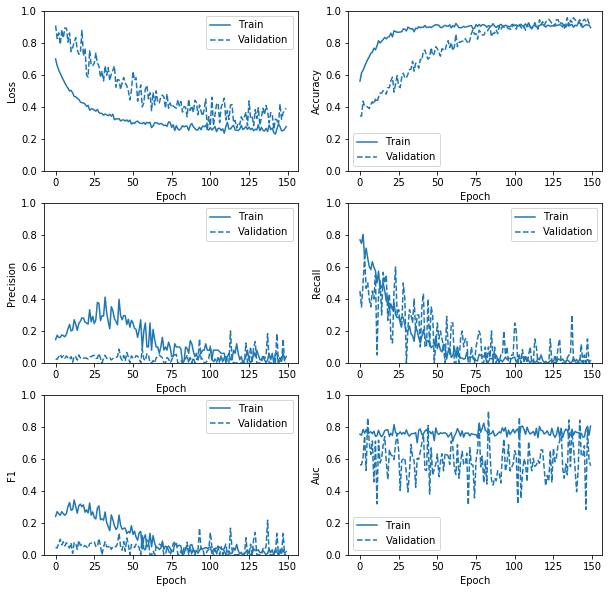

In [25]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/150
50/50 [==============================] - 22s 446ms/step - loss: 0.1816 - Accuracy: 0.9525 - Precision: 0.0400 - Recall: 0.0117 - F1: 0.0180 - AUC: 0.7944 - val_loss: 0.4282 - val_Accuracy: 0.9219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5655
Epoch 2/150
50/50 [==============================] - 26s 514ms/step - loss: 0.1782 - Accuracy: 0.9550 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7623 - val_loss: 0.2770 - val_Accuracy: 0.9406 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.5978
Epoch 3/150
50/50 [==============================] - 21s 425ms/step - loss: 0.1883 - Accuracy: 0.9475 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7976 - val_loss: 0.3138 - val_Accuracy: 0.9312 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4664
Epoch 4/150
50/50 [==============================] - 22s 441ms/step - loss: 0.1731 - Accuracy: 0.959

Epoch 28/150
50/50 [==============================] - 23s 461ms/step - loss: 0.1969 - Accuracy: 0.9438 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7409 - val_loss: 0.2429 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5775
Epoch 29/150
50/50 [==============================] - 20s 397ms/step - loss: 0.1882 - Accuracy: 0.9475 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7380 - val_loss: 0.3016 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5857
Epoch 30/150
50/50 [==============================] - 24s 480ms/step - loss: 0.1700 - Accuracy: 0.9519 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7866 - val_loss: 0.2708 - val_Accuracy: 0.9438 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.8440
Epoch 31/150
50/50 [==============================] - 19s 389ms/step - lo

Epoch 55/150
50/50 [==============================] - 20s 399ms/step - loss: 0.1823 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7326 - val_loss: 0.1779 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6286
Epoch 56/150
50/50 [==============================] - 24s 488ms/step - loss: 0.1743 - Accuracy: 0.9531 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7306 - val_loss: 0.2719 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4664
Epoch 57/150
50/50 [==============================] - 20s 396ms/step - loss: 0.1697 - Accuracy: 0.9544 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7169 - val_loss: 0.3029 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5241
Epoch 58/150
50/50 [==============================] - 20s 409

50/50 [==============================] - 24s 483ms/step - loss: 0.1886 - Accuracy: 0.9481 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7154 - val_loss: 0.1878 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7660
Epoch 82/150
50/50 [==============================] - 20s 396ms/step - loss: 0.1447 - Accuracy: 0.9613 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7875 - val_loss: 0.2543 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6313
Epoch 83/150
50/50 [==============================] - 20s 401ms/step - loss: 0.1824 - Accuracy: 0.9456 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7908 - val_loss: 0.2073 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5779
Epoch 84/150
50/50 [==============================] - 23s 464ms/step - los

50/50 [==============================] - 21s 423ms/step - loss: 0.1474 - Accuracy: 0.9588 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8044 - val_loss: 0.2223 - val_Accuracy: 0.9775 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8147
Epoch 108/150
50/50 [==============================] - 24s 470ms/step - loss: 0.1959 - Accuracy: 0.9419 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7706 - val_loss: 0.2409 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5214
Epoch 109/150
50/50 [==============================] - 20s 407ms/step - loss: 0.1692 - Accuracy: 0.9525 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7671 - val_loss: 0.2098 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7282
Epoch 110/150
50/50 [==============================] - 22s 432ms/step - 

50/50 [==============================] - 24s 483ms/step - loss: 0.1543 - Accuracy: 0.9550 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8311 - val_loss: 0.1331 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5122
Epoch 134/150
50/50 [==============================] - 19s 388ms/step - loss: 0.1691 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7328 - val_loss: 0.1837 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7731
Epoch 135/150
50/50 [==============================] - 20s 391ms/step - loss: 0.1810 - Accuracy: 0.9506 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7286 - val_loss: 0.1975 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4003
Epoch 136/150
50/50 [==============================] - 23s 466ms/step - loss: 0.1770

In [27]:
print("Time taken:",end-start)

Time taken: 3237.05455160141


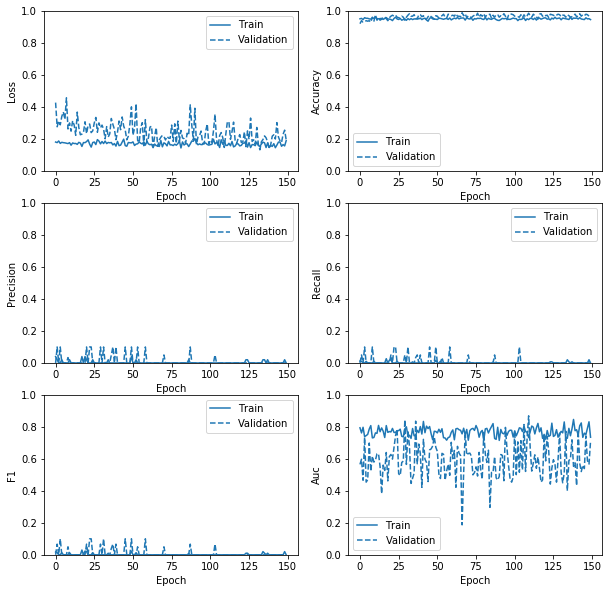

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [33]:
# print("Time taken:",end-start)

In [34]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 21s 210ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.201 :   0.145
Accuracy : 0.977 :   0.973
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.622 :   0.628


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1290.2417209148407, 204.1887354850769)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [40]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

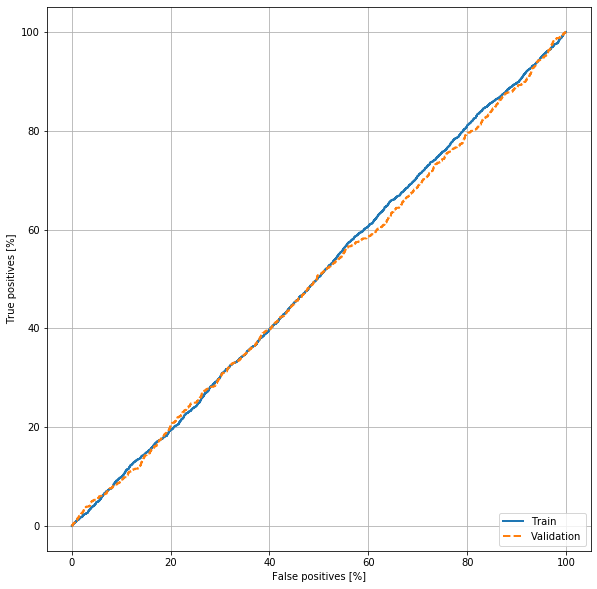

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99254 
FP: 201 
FN: 2375 
TP: 4
Healthy Patients - correctly identified (True Negatives):  99254 0.997978985470816
Healthy Patients - predicted to have glaucoma (False Positives):  201 0.002021014529184053
Glaucoma Patients - predicted healthy (False Negatives):  2375 0.9983186212694409
Glaucoma Patients - correctly identified (True Positives):  4 0.0016813787305590584

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


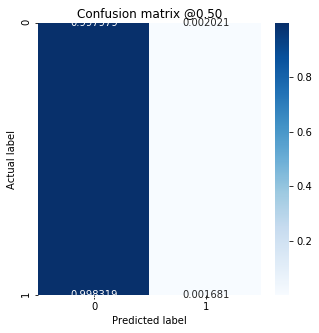

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33065 
FP: 69 
FN: 807 
TP: 2
Healthy Patients - correctly identified (True Negatives):  33065 0.9979175469306453
Healthy Patients - predicted to have glaucoma (False Positives):  69 0.0020824530693547413
Glaucoma Patients - predicted healthy (False Negatives):  807 0.9975278121137207
Glaucoma Patients - correctly identified (True Positives):  2 0.002472187886279357

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


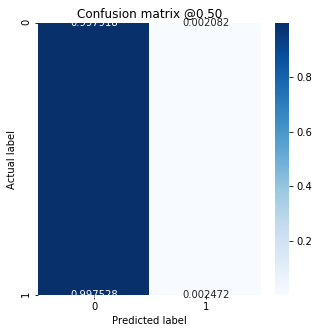

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 84 tr layers and no cw"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [45]:
# client = MlflowClient()
# run = client.create_run('18')
# client.set_tag(run.info.run_id, "tag_key", tag_value)